# Detecting COVID-19 with Chest X Ray using PyTorch

Image classification of Chest X Rays in one of three classes: Normal, Viral Pneumonia, COVID-19


# Importing Libraries

In [42]:
%matplotlib inline
 
import os
import shutil
import random
import torch
import torchvision
import numpy as np

from PIL import Image
from matplotlib import pyplot as pltby

torch.manual_seed(0)

print('Using PyTorch version', torch.__version__)

Using PyTorch version 1.5.0


# Preparing Training and Test Sets

In [22]:
class_names = ['normal', 'viral', 'covid']
root_dir = 'COVID-19_Radiography_Database'
source_dirs = ['Normal', 'Viral', 'COVID']

if os.path.isdir(os.path.join(root_dir, source_dirs[1])):
    os.mkdir(os.path.join(root_dir, 'test'))

    for i, d in enumerate(source_dirs):
        os.rename(os.path.join(root_dir, d), os.path.join(root_dir, class_names[i]))

    for c in class_names:
        os.mkdir(os.path.join(root_dir, 'test', c))

    for c in class_names:
        images = [x for x in os.listdir(os.path.join(root_dir, c)) if x.lower().endswith('png')]
        selected_images = random.sample(images, 30)
        for image in selected_images:
            source_path = os.path.join(root_dir, c, image)
            target_path = os.path.join(root_dir, 'test', c, image)
            shutil.move(source_path, target_path)

# Creating Custom Dataset

In [23]:
class ChestXRayDataset(torch.utils.data.Dataset):
    def __init__(self, image_dirs, transform):#transform for data augmentation here only for training data
        def get_images(class_name):
            images = [x for x in os.listdir(image_dirs[class_name]) if x.lower().endswith('png')]
            print(f'Found {len(images)} {class_name} examples')
            return images
        
        self.images = {}
        self.class_names = ['normal', 'viral', 'covid']
        
        for c in self.class_names:
            self.images[c] = get_images(c)
            
        self.image_dirs = image_dirs
        self.transform = transform
        
    def __len__(self):
        return sum([len(self.images[c]) for c in self.class_names])
    
    def __getitem__(self, index):
        class_name = random.choice(self.class_names)
        index = index % len(self.images[class_name])
        image_name = self.images[class_name][index]
        image_path = os.path.join(self.image_dirs[class_name], image_name)
        image = Image.open(image_path).convert('RGB')
        return self.transform(image), self.class_names.index(class_name)

# Image Transformations

In [24]:
train_transform = torchvision.transforms.Compose([
    torchvision.transforms.Resize(size=(224,224)),
    torchvision.transforms.RandomHorizontalFlip(),#data agmentation
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                    std=[0.229, 0.224, 0.225])
])


test_transform = torchvision.transforms.Compose([
    torchvision.transforms.Resize(size=(224,224)),
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                    std=[0.229, 0.224, 0.225])
])

# Prepare DataLoader

In [25]:
train_dirs = {
    'normal': 'COVID-19_Radiography_Database/normal',
    'viral': 'COVID-19_Radiography_Database/viral',
    'covid': 'COVID-19_Radiography_Database/covid'
}

train_dataset = ChestXRayDataset(train_dirs, train_transform)

Found 10162 normal examples
Found 1315 viral examples
Found 3586 covid examples


In [26]:
test_dirs = {
    'normal': 'COVID-19_Radiography_Database/test/normal',
    'viral': 'COVID-19_Radiography_Database/test/viral',
    'covid': 'COVID-19_Radiography_Database/test/covid'
}
test_dataset = ChestXRayDataset(test_dirs, test_transform)

Found 30 normal examples
Found 30 viral examples
Found 30 covid examples


In [27]:
batch_size = 6

dl_train = torch.utils.data.DataLoader(train_dataset, batch_size = batch_size,
                                      shuffle=True) #not taking samples in sequence

dl_test = torch.utils.data.DataLoader(test_dataset, batch_size = batch_size,
                                      shuffle=True)

print('Num of training batches', len(dl_train))
print('Num of test batches', len(dl_test))


Num of training batches 2511
Num of test batches 15


# Data Visualization

In [28]:
class_names = train_dataset.class_names

def show_images(images, labels, preds):     #we dont have predictions at this point
    plt.figure(figsize=(8,4))
    for i, image in enumerate(images): 
        plt.subplot(1, 6, i + 1, xticks=[], yticks=[]) #subplot has 1 row and 6 columns, the 6 images from 1 batch will be displayed in the same row
        #convert tenor image to numpy array
        image = image.numpy().transpose((1, 2, 0))
        mean = np.array([0.485, 0.456, 0.406])
        std = np.array([0.229, 0.224, 0.225])
        image = image * std + mean #convert to before normalization
        image = np.clip(image, 0., 1.)
        plt.imshow(image)
    
        col = 'green' if preds[i] == labels[i] else 'red'
        
        plt.xlabel(f'{class_names[int(labels[i].numpy())]}')
        plt.ylabel(f'{class_names[int(preds[i].numpy())]}', color=col)   
    plt.tight_layout()
    plt.show()

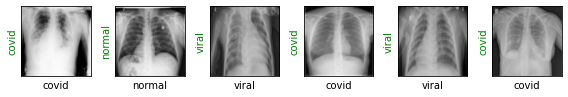

In [29]:
images, labels = next(iter(dl_train))
show_images(images, labels, labels)

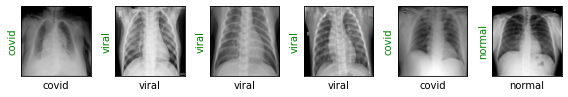

In [30]:
images, labels = next(iter(dl_test))
show_images(images, labels, labels)

# Creating the Model

In [33]:
#fix unverified SSL problem on Mac
import ssl
ssl._create_default_https_context = ssl._create_unverified_context

In [34]:
resnet18 = torchvision.models.resnet18(pretrained=True)
print(resnet18)

Downloading: "https://download.pytorch.org/models/resnet18-5c106cde.pth" to /Users/caimeng/.cache/torch/checkpoints/resnet18-5c106cde.pth


  0%|          | 0.00/44.7M [00:00<?, ?B/s]

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [35]:
#(fc): Linear(in_features=512, out_features=1000, bias=True)
#this is the part we want to change
resnet18.fc = torch.nn.Linear(in_features=512, out_features=3)
loss_fn = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(resnet18.parameters(), lr=3e-5)

In [36]:
def show_preds():
    resnet18.eval()
    images, labels = next(iter(dl_test))
    outputs = resnet18(images)
    _, preds = torch.max(outputs, 1) #dimension1 is the output values
    show_images(images, labels, preds)

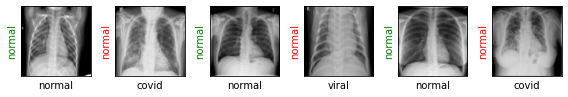

In [37]:
show_preds()

# Training the Model

In [38]:
def train(epochs): 
    print('Starting training ..')
    for e in range(0, epochs):
        print('='*20)
        print(f'Starting epoch {e + 1}/{epochs}')
        print('='*20)
    
        train_loss = 0
        
        resnet18.train()   #set training mode to true
        
        for train_step, (images, labels) in enumerate(dl_train):
            optimizer.zero_grad()   #refresh optimizer and set gradients to 0
            outputs = resnet18(images)
            loss = loss_fn(outputs, labels)
            loss.backward() 
            optimizer.step()
            train_loss += loss.item()
            if train_step % 20 ==0:  #we evalute our model every 20 step
                print('Evaluating at step', train_step)
                acc = 0.   #accuracy
                val_loss = 0.
                resnet18.eval() 
                
                for val_step, (images, labels) in enumerate(dl_test):
                    outputs = resnet18(images)
                    loss = loss_fn(outputs, labels)
                    val_loss += loss.item()
                    
                    _, preds = torch.max(outputs, 1)
                    acc += sum((preds == labels).numpy())
                val_loss /= (val_step + 1)
                acc = acc / len(test_dataset)
                print(f'Val loss: {val_loss:.4f}, Acc: {acc:.4f}')
                show_preds()
                
                resnet18.train()
                
                if acc > 0.95:
                    print('Performance condition satisfied')
                    return 
        train_loss /= (train_step + 1)
        print(f'Training Loss: {train_loss:.4f}')
    

Starting training ..
Starting epoch 1/1
Evaluating at step 0
Val loss: 1.2551, Acc: 0.2889


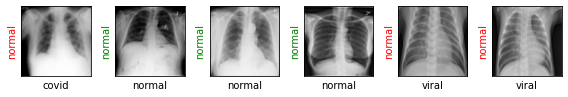

Evaluating at step 20
Val loss: 0.7450, Acc: 0.7111


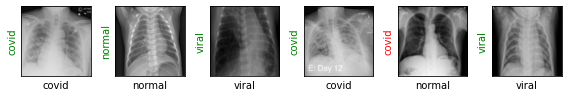

Evaluating at step 40
Val loss: 0.4316, Acc: 0.8333


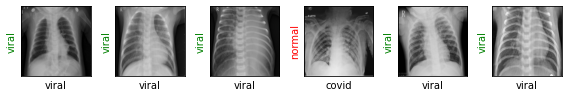

Evaluating at step 60
Val loss: 0.3909, Acc: 0.8222


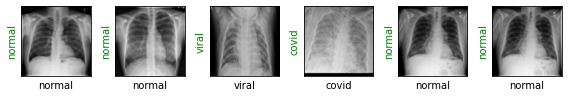

Evaluating at step 80
Val loss: 0.2732, Acc: 0.9222


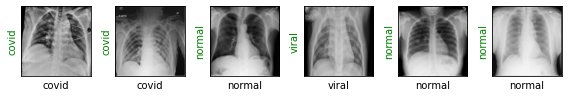

Evaluating at step 100
Val loss: 0.2874, Acc: 0.8778


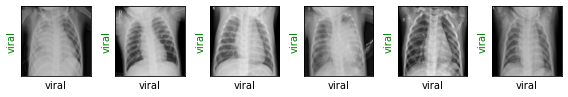

Evaluating at step 120
Val loss: 0.4308, Acc: 0.8222


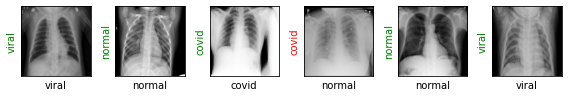

Evaluating at step 140
Val loss: 0.1592, Acc: 0.9778


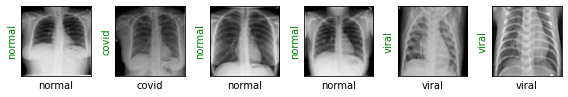

Performance condition satisfied


In [39]:
train(epochs=1)

# Final Results

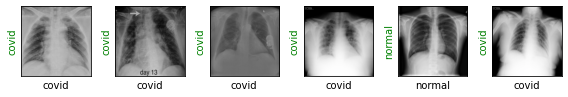

In [40]:
show_preds()